<a href="https://colab.research.google.com/github/pankaj846/Text_Detection_Recognition/blob/main/Text_Detection_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

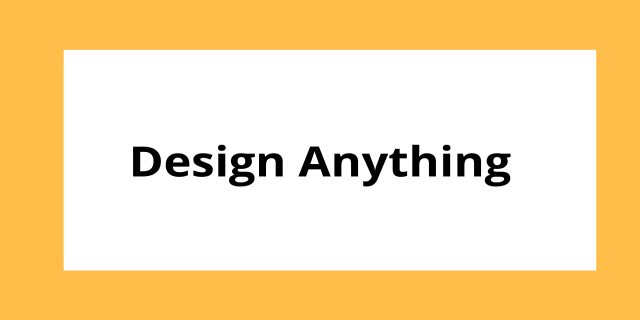

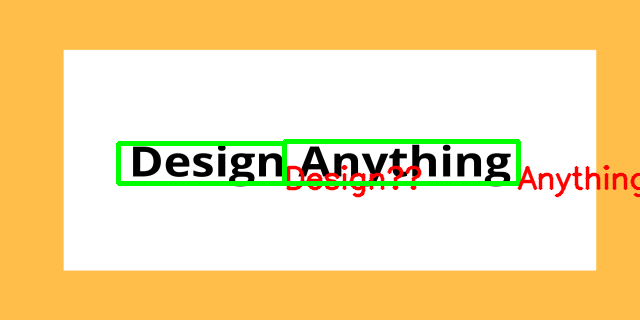

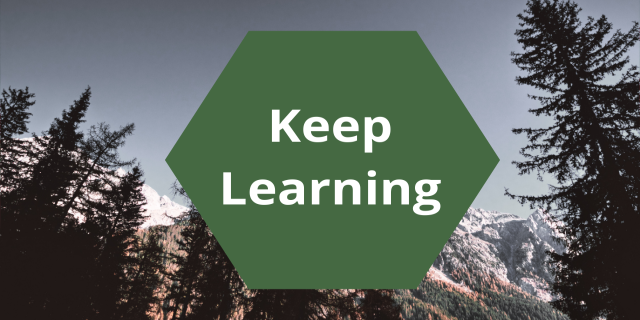

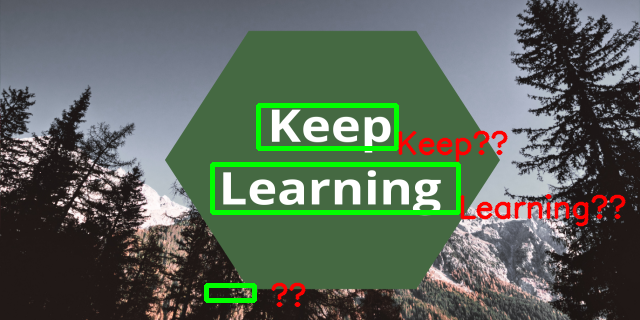

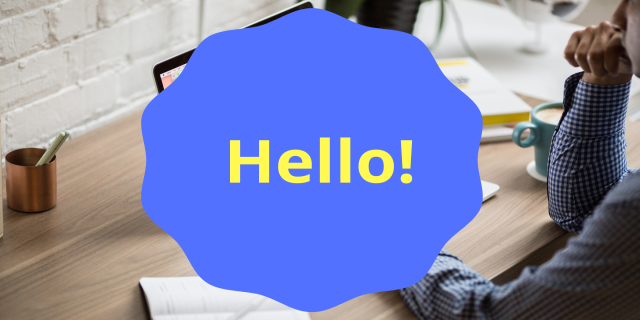

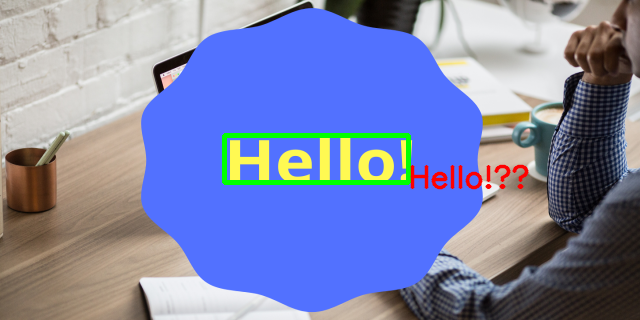

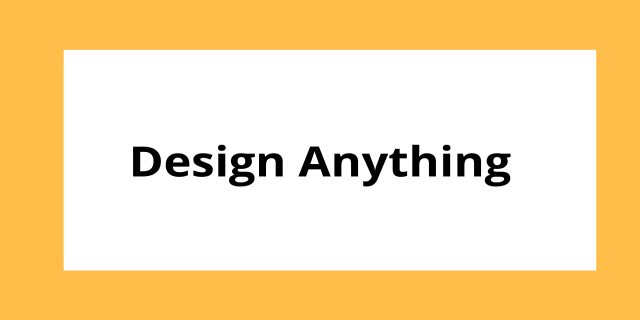

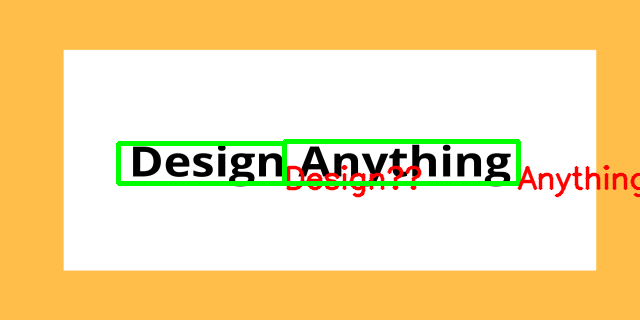

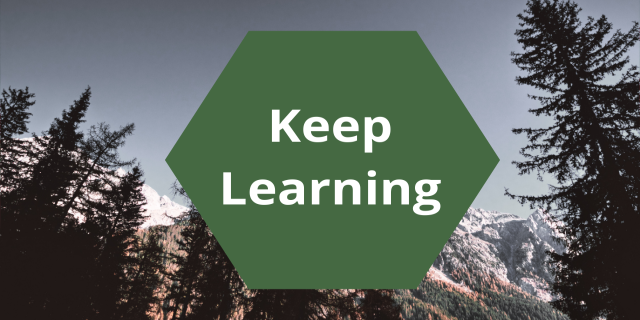

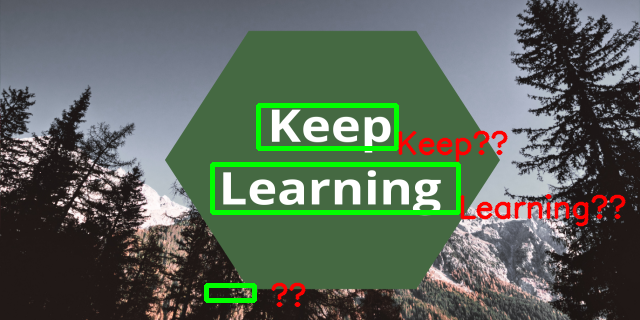

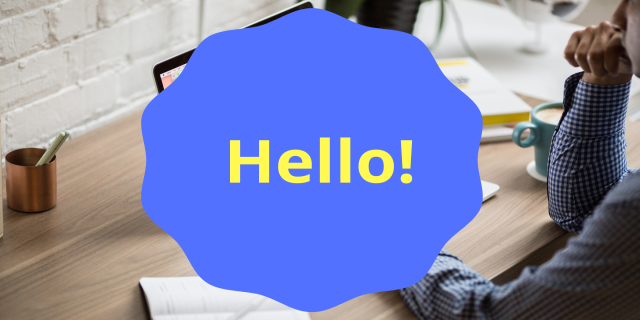

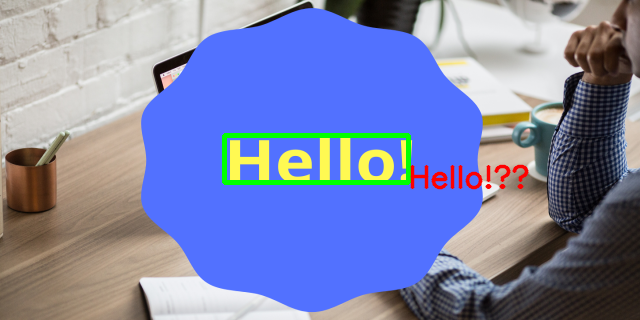

In [85]:
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
import numpy as np
import time
import cv2
import pytesseract

net = cv2.dnn.readNet("/content/drive/MyDrive/textDetection-Recognition-master/frozen_east_text_detection.pb")


def text_detector(image):
	orig = image
	(H, W) = image.shape[:2]

	(newW, newH) = (320, 320)
	rW = W / float(newW)
	rH = H / float(newH)

	image = cv2.resize(image, (newW, newH))
	(H, W) = image.shape[:2]

	layerNames = [
		"feature_fusion/Conv_7/Sigmoid",
		"feature_fusion/concat_3"]


	blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
		(123.68, 116.78, 103.94), swapRB=True, crop=False)

	net.setInput(blob)
	(scores, geometry) = net.forward(layerNames)

	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	for y in range(0, numRows):

		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability, ignore it
			if scoresData[x] < 0.5:
				continue

			# compute the offset factor as our resulting feature maps will
			# be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and then
			# compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height of
			# the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates for
			# the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score to
			# our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	boxes = non_max_suppression(np.array(rects), probs=confidences)

	for (startX, startY, endX, endY) in boxes:

		startX = int(startX * rW)
		startY = int(startY * rH)
		endX = int(endX * rW)
		endY = int(endY * rH)
		boundary = 2

		text = orig[startY-boundary:endY+boundary, startX - boundary:endX + boundary]
		text = cv2.cvtColor(text.astype(np.uint8), cv2.COLOR_BGR2GRAY)
		textRecongized = pytesseract.image_to_string(text)
		cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 3)
		orig = cv2.putText(orig, textRecongized, (endX,endY+5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA) 
	return orig

image1 = cv2.imread('/content/1.png')
image2 = cv2.imread('/content/2.png')
image3 = cv2.imread('/content/3.png')

array = [image1, image2, image3]

for i in range(0,2):
	for img in array:
		imageO = cv2.resize(img, (640,320), interpolation = cv2.INTER_AREA)
		orig = cv2.resize(img, (640,320), interpolation = cv2.INTER_AREA)
		textDetected = text_detector(imageO)
		cv2_imshow(orig)
		cv2_imshow(textDetected)
		time.sleep(2)
		k = cv2.waitKey(30)
		if k == 27:
			break
cv2.destroyAllWindows()